In [1]:
from SimPEG import Mesh, Utils, Maps, Survey
from SimPEG.EM.Static import DC, IP
from pymatsolver import MumpsSolver
from ipywidgets import interact, IntSlider
import sys
sys.path.append("../utilcodes/")
from vizutils import viz, gettopoCC, vizEJ
%pylab inline
import matplotlib
matplotlib.rcParams['font.size'] = 14
import matplotlib.patches as patches

Populating the interactive namespace from numpy and matplotlib


# DC example: Gradient array with single source

$$\vec{j} = \sigma \vec{e}$$

$$\vec{e} = -\nabla \phi$$

$$\nabla \cdot \vec{j} = -\vec{j}_s = I_0 (\delta(\vec{r}-\vec{r}_+)-\delta(\vec{r}-\vec{r}_-))$$

$$\vec{j} \cdot \hat{n} \ \Big|_{\partial \Omega} = 0$$ 

- $\vec{j}$: Current density (A/m $^2$)

- $\vec{e}$: Electric field (V/m)

- $I_0$: Current (A)

- $\delta$: Volumetric delta function (m $^{-3}$)

<img src="./images/DCIP_kimberlites.png" width=500> </img>

## Mesh and Conductivity model

In [2]:
csx, csy, csz = 25., 25., 25.
ncx, ncy, ncz = 48, 48, 20
npad = 7
hx = [(csx,npad, -1.3),(csx,ncx),(csx,npad, 1.3)]
hy = [(csy,npad, -1.3),(csy,ncy),(csy,npad, 1.3)]
hz = [(csz,npad, -1.3),(csz,ncz), (csz/2.,6)]
mesh = Mesh.TensorMesh([hx, hy, hz],x0="CCN")
xc = 300+5.57e5
yc = 600+7.133e6
zc = 425.
mesh._x0 = mesh.x0 + np.r_[xc, yc, zc]
sigma = mesh.readModelUBC("VTKout_DC.dat")
airind = sigma == 1e-8

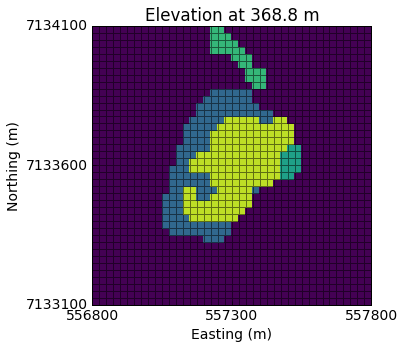

In [3]:
ax = viz(mesh, sigma, 28, airind, normal="Z", xc=xc, yc=yc, zc=zc, cb=False)
# ax.set_xticks(np.linspace(xmin, xmax, 3))
# ax.set_yticks([]); ax.set_ylabel('')

(<matplotlib.axes._subplots.AxesSubplot at 0x111693710>,
 (<matplotlib.collections.QuadMesh at 0x11195d1d0>,
  <matplotlib.lines.Line2D at 0x11195d710>))

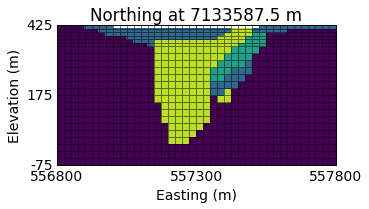

In [4]:
viz(mesh, sigma, 30, airind, normal="Y", xc=xc, yc=yc, zc=zc, clim=(-4, -1), cb=False)

## Obtain topographic surface from 3D conductivity model

In [5]:
mesh2D, topoCC = gettopoCC(mesh, airind)

## Gradient array for DC survey

In [6]:
# A source location (A-B electrodes, x-direction)
Aloc1_x = np.r_[-600., 0, 0.] + np.r_[xc, yc, zc]
Bloc1_x = np.r_[600., 0, 0.] + np.r_[xc, yc, zc]

# Rx locations (M-N electrodes, x-direction)
x = mesh.vectorCCx[np.logical_and(mesh.vectorCCx>-300.+ xc, mesh.vectorCCx<300.+ xc)] 
y = mesh.vectorCCy[np.logical_and(mesh.vectorCCy>-300.+ yc, mesh.vectorCCy<300.+ yc)] 
Mx = Utils.ndgrid(x[:-1], y, np.r_[-12.5/2.])
Nx = Utils.ndgrid(x[1:], y, np.r_[-12.5/2.])
inds_Mx = Utils.closestPoints(mesh2D, Mx[:,:2])
inds_Nx = Utils.closestPoints(mesh2D, Nx[:,:2])
Mx_dr = np.c_[Mx[:,0], Mx[:,1], topoCC[inds_Mx]]
Nx_dr = np.c_[Nx[:,0], Nx[:,1], topoCC[inds_Nx]]

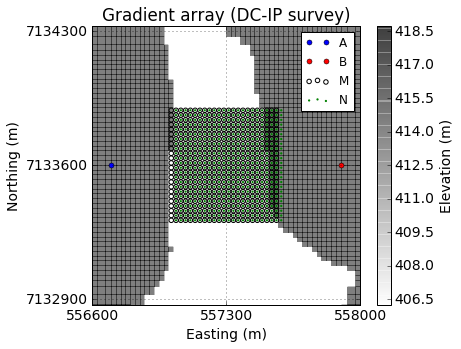

In [7]:
fig, ax = plt.subplots(1,1, figsize=(5*1.2,5))
dat = mesh2D.plotImage(topoCC,pcolorOpts={"cmap":"binary",'alpha':0.5}, ax=ax)
plt.xlabel("Easting (m)"); plt.ylabel("Northing (m)")
cb = plt.colorbar(dat[0]); cb.set_label("Elevation (m)")
ax.plot(Aloc1_x[0], Aloc1_x[1], 'bo', ms=5)
ax.plot(Bloc1_x[0], Bloc1_x[1], 'ro', ms=5)
ax.scatter(Mx[:,0], Mx[:,1],s=20, edgecolors="k", facecolors="none")
ax.scatter(Nx[:,0], Nx[:,1],s=5, edgecolors="none", facecolors="g")
ax.legend(("A", "B", "M", "N"), fontsize=12)
xmin, xmax = -700+xc, 700+xc
ymin, ymax = -700+yc, 700+yc
ax.set_xticks(np.linspace(xmin, xmax, 3))
ax.set_yticks(np.linspace(ymin, ymax, 3))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.axis('equal')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")  
ax.set_title("Gradient array (DC-IP survey)")
ax.grid(True)
fig.savefig("./images/GradientArray", dpi=200)

In [8]:
# Src and Rx classes for DC problem
rx_x = DC.Rx.Dipole(Mx_dr, Nx_dr)
src1 = DC.Src.Dipole([rx_x], Aloc1_x, Bloc1_x)

In [9]:
# Inversion model is log conductivity in the subsurface
# This can be realized as a following mapping:
expmap = Maps.ExpMap(mesh) # from log conductivity to conductivity
actmap = Maps.InjectActiveCells(mesh, ~airind, np.log(1e-8)) # from subsurface cells to full3D cells
mapping = expmap*actmap

In [10]:
# Inital and reference model
m0 = np.ones_like(sigma)[~airind]*np.log(1e-4)

## Compute fields
1. Current density: $\mathbf{j} = \sigma \mathbf{e} = -\sigma \nabla \phi$
2. Charge:  $\int_V \epsilon_0 \nabla \cdot \vec{e} dV = \int_V\rho_v dV$ 

$\rho_v$: Volumetric charge density (C/m $^3$), $\epsilon_0$: Dielectric constant in free-space (F/m)

3. Secondary potential: $\phi_s = \phi-\phi_0$

$ \phi = F[\sigma] $ , $\phi_0 = F[\sigma_{halfspace}] $



In [11]:
%%time
# Form survey object using Srcs and Rxs that we have generated
survey = DC.Survey([src1])
problem = DC.Problem3D_CC(mesh, mapping=mapping)
problem.Solver = MumpsSolver
problem.pair(survey)
mtrue = np.log(sigma)[~airind]
# Compute fields
f0 = problem.fields(m0)
f = problem.fields(mtrue)

CPU times: user 30.6 s, sys: 1.49 s, total: 32.1 s
Wall time: 10.7 s


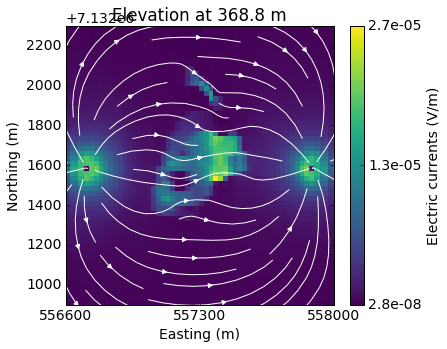

In [13]:
ax, dat = vizEJ(mesh, sigma, 28, f=f, airind=airind, src=src1, normal="Z", ftype="J", xc=xc, yc=yc, zc=zc, cb=True)

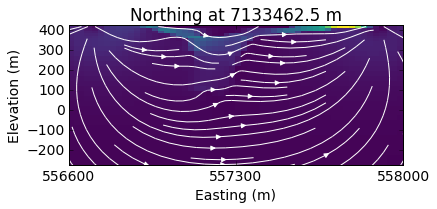

In [14]:
ax, dat = vizEJ(mesh, sigma, 25, f=f, airind=airind, src=src1, normal="Y", ftype="J", xc=xc, yc=yc, zc=zc, cb=False)

(<matplotlib.axes._subplots.AxesSubplot at 0x119b2b890>,
 (<matplotlib.collections.QuadMesh at 0x111a6c290>,))

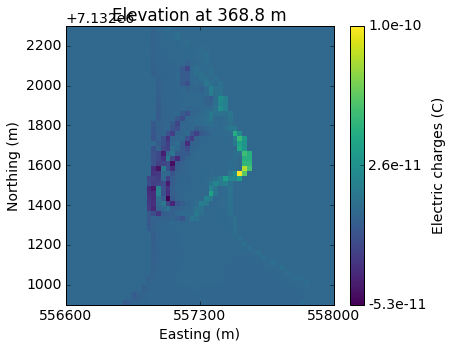

In [15]:
vizEJ(mesh, sigma, 28, f=f, airind=airind, src=src1, normal="Z", ftype="charg", xc=xc, yc=yc, zc=zc,)
# ax.set_ylabel('')


(<matplotlib.axes._subplots.AxesSubplot at 0x119b43f50>,
 (<matplotlib.collections.QuadMesh at 0x118bbf510>,))

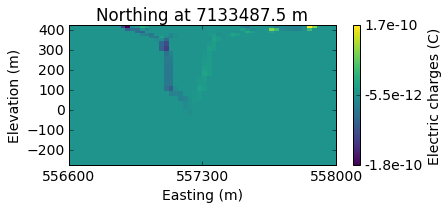

In [16]:
vizEJ(mesh, sigma, 26, f=f, airind=airind, src=src1, normal="Y", ftype="charg", xc=xc, yc=yc, zc=zc)
# ax.set_yticks([])
# ax.set_ylabel('')

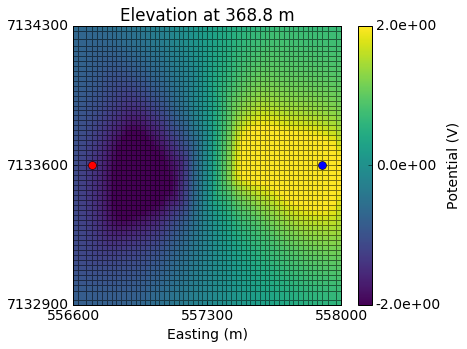

In [19]:
#anomalous potential
phi_sec = f[src1, "phi"] - f0[src1, "phi"]

ax, dat = viz(mesh, phi_sec, 28, airind, normal="Z", xc=xc, yc=yc, zc=zc, scale="linear", clim=(-2,2), label="Potential (V)")
ax.plot(Aloc1_x[0], Aloc1_x[1], 'ro', ms=8)
ax.plot(Bloc1_x[0], Bloc1_x[1], 'bo', ms=8)
xmin, xmax = -700+xc, 700+xc
ymin, ymax = -700+yc, 700+yc
ax.set_xticks(np.linspace(xmin, xmax, 3))
ax.set_yticks(np.linspace(ymin, ymax, 3))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax); ax.set_ylabel('')


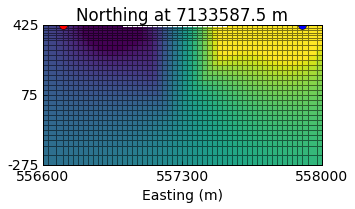

In [20]:
ax,dat = viz(mesh, phi_sec, 30, airind, normal="Y", xc=xc, yc=yc, zc=zc, scale="linear", clim=(-2, 2), label="Potential (V)", cb=None)
xmin, xmax = -700+xc, 700+xc
ymin, ymax = -700+zc, 0+zc

ax.plot(Aloc1_x[0], Aloc1_x[2], 'ro', ms=8)
ax.plot(Bloc1_x[0], Bloc1_x[2], 'bo', ms=8)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xticks(np.linspace(xmin, xmax, 3))
ax.set_yticks(np.linspace(ymin, ymax, 3))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax); ax.set_ylabel('')
# cb = plt.colorbar(dat[0], ax=ax)

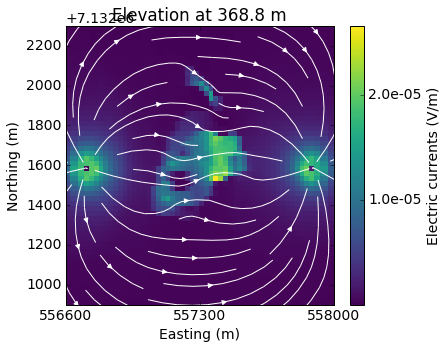

In [36]:
ax, dat = vizEJ(mesh, sigma, 28, f=f, airind=airind, src=src1, normal="Z", ftype="J", xc=xc, yc=yc, zc=zc, clim=(0,2e-5), cb=True)

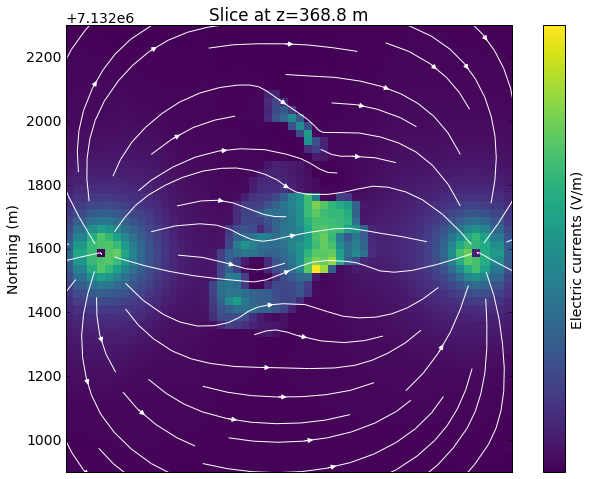

In [37]:
fig = plt.figure(figsize(11, 8))
Imin, Imax = 0, 2.7e-8
Qmin, Qmax = 0, 1e-10
Vsmin, Vsmax = -2., 2.
xmin, xmax = -700+xc, 700+xc
ymin, ymax = -700+yc, 700+yc
zmin, zmax = -700+zc, 0+zc
indz = 28
indy = 31
# Axis label
x = np.linspace(xmin+200, xmax-200,3)


ax1 = plt.subplot(1,1,1)
pos =  ax1.get_position()
ax1.set_position([pos.x0-0.1, pos.y0+0.3,  pos.width*0.5, pos.height*0.5])
ax1,dat1 = vizEJ(mesh, sigma, indz, f=f, airind=airind, src=src1, normal="Z", ftype="J", xc=xc, yc=yc, zc=zc, clim=(Imin, Imax), ax=ax1, cb=True)
#ax, dat = vizEJ(mesh, sigma,   28, f=f, airind=airind, src=src1, normal="Z", ftype="J", xc=xc, yc=yc, zc=zc,     clim=(0,2e-5),         cb=True)

plt.gca().set_aspect('equal')
ax1.set_title(("Slice at z=%.1f m")%(mesh.vectorCCz[indz]))
ax1.xaxis.set_visible(False)
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)    
ax1.set_ylabel('Northing (m)')

# # ax2 = plt.subplot(2,2,3)
# pos =  ax1.get_position()
# ax2 = fig.add_axes([pos.x0+0.0525, pos.y0 - 0.36,  pos.width*0.725, pos.height])
# # ax2.yaxis.set_visible(False)
# # ax2.set_position([pos.x0 -0.04 , pos.y0,  pos.width, pos.height])

# ax2, dat2 = vizEJ(mesh, sigma, indy, f=f, airind=airind, src=src1, normal="Y", ftype="J", xc=xc, yc=yc, zc=zc, clim=(Imin, Imax), ax=ax2, cb=False)
# #     plt.colorbar(dat[0])
# plt.gca().set_aspect('equal')
# ax2.set_title(("Slice at y=%.1f m")%(mesh.vectorCCy[indy]))
# ax2.set_xlim(xmin, xmax)
# ax2.set_ylim(zmin, zmax) 
# ax2.set_xticks(map(int, x))
# ax2.set_xticklabels(map(str, map(int, x)),size=12)
# ax2.set_xlabel('Easting (m)')
# ax2.set_ylabel('Elev. (m)')

# cbI = plt.colorbar(dat1[0],orientation="horizontal", format="%1.1e", ticks=np.linspace(Imin, Imax, 3))
# cbI_label = "Electric currents (V/m)"
# cbI.set_label(cbI_label)


# ax3 = fig.add_axes([pos.x0+0.3, pos.y0,  pos.width, pos.height])
# ax3,dat3 = vizEJ(mesh, sigma, indz, f=f, airind=airind, src=src1, normal="Z", ftype="charg", xc=xc, yc=yc, zc=zc, clim=(Qmin, Qmax), ax=ax3, cb=False)
# # dat = mesh.plotSlice(m_l2, ax = ax1, normal='Z', ind=indz, clim=np.r_[vmin, vmax],pcolorOpts={'cmap':'viridis'})
# #     plt.colorbar(dat[0])
# plt.gca().set_aspect('equal')
# # plt.title('Currents')
# ax3.set_title(("Slice at z=%.1f m")%(mesh.vectorCCz[indz]))
# ax3.xaxis.set_visible(False)
# ax3.yaxis.set_visible(False)
# ax3.set_xlim(xmin, xmax)
# ax3.set_ylim(ymin, ymax)


# ax4 = fig.add_axes([pos.x0+0.3525, pos.y0 - 0.36,  pos.width*0.725, pos.height])
# # ax2.yaxis.set_visible(False)
# # ax2.set_position([pos.x0 -0.04 , pos.y0,  pos.width, pos.height])

# ax4, dat4 = vizEJ(mesh, sigma, indy, f=f, airind=airind, src=src1, normal="Y", ftype="charg", xc=xc, yc=yc, zc=zc, clim=(Qmin, Qmax), ax=ax4, cb=False)
# #     plt.colorbar(dat[0])
# plt.gca().set_aspect('equal')
# ax4.set_title(("Slice at y=%.1f m")%(mesh.vectorCCy[indy]))
# ax4.yaxis.set_visible(False)
# ax4.set_xlim(xmin, xmax)
# ax4.set_ylim(zmin, zmax) 
# ax4.set_xticks(map(int, x))
# ax4.set_xticklabels(map(str, map(int, x)),size=12)
# ax4.set_xlabel('Easting (m)')

# cbQ = plt.colorbar(dat4[0],orientation="horizontal", format="%1.1e", ticks=np.linspace(Qmin, Qmax, 3))
# cbQ_label = "Electric charges (C)"
# cbQ.set_label(cbQ_label)



# # ## Add True model
# # ax5 = fig.add_axes([pos.x0+0.6, pos.y0,  pos.width, pos.height])
# # dat = mesh.plotSlice(m_true, ax = ax5, normal='Z', ind=indz, clim=np.r_[vmin, vmax],pcolorOpts={'cmap':'viridis'})
# # #     plt.colorbar(dat[0])
# # plt.gca().set_aspect('equal')
# # plt.title('True model')
# # ax5.xaxis.set_visible(False)
# # ax5.yaxis.set_visible(False)
# # xlim(xmin, xmax)
# # ylim(ymin, ymax)    

# # ax6 = fig.add_axes([pos.x0+0.6525, pos.y0 - 0.315,  pos.width*0.725, pos.height])
# # # ax2.yaxis.set_visible(False)
# # # ax2.set_position([pos.x0 -0.04 , pos.y0,  pos.width, pos.height])

# # dat = mesh.plotSlice(m_true, ax = ax6, normal='Y', ind=indx, clim=np.r_[vmin, vmax],pcolorOpts={'cmap':'viridis'})
# # #     plt.colorbar(dat[0])
# # plt.gca().set_aspect('equal')
# # ax6.yaxis.set_visible(False)
# # plt.title('')
# # xlim(xmin, xmax)
# # ylim(zmin, zmax) 
# # ax6.set_xticks(map(int, x))
# # ax6.set_xticklabels(map(str, map(int, x)),size=12)
# # xlabel('Easting (m)')
# # ylabel('Elev. (m)')

# ax5 = fig.add_axes([pos.x0+0.6, pos.y0,  pos.width, pos.height])
# ax5,dat5 = viz(mesh, phi_sec, indz, airind, normal="Z", xc=xc, yc=yc, zc=zc, scale="linear", clim=(Vsmin, Vsmax), ax=ax5, cb=False)
# # dat = mesh.plotSlice(m_l2, ax = ax1, normal='Z', ind=indz, clim=np.r_[vmin, vmax],pcolorOpts={'cmap':'viridis'})
# #     plt.colorbar(dat[0])
# ax5.plot(Aloc1_x[0], Aloc1_x[1], 'ro', ms=8)
# ax5.plot(Bloc1_x[0], Bloc1_x[1], 'bo', ms=8)
# plt.gca().set_aspect('equal')
# # plt.title('Currents')
# ax5.set_title(("Slice at z=%.1f m")%(mesh.vectorCCz[indz]))
# ax5.xaxis.set_visible(False)
# ax5.yaxis.set_visible(False)
# ax5.set_xlim(xmin, xmax)
# ax5.set_ylim(ymin, ymax)


# ax6 = fig.add_axes([pos.x0+0.6525, pos.y0 - 0.36,  pos.width*0.725, pos.height])
# # ax2.yaxis.set_visible(False)
# # ax2.set_position([pos.x0 -0.04 , pos.y0,  pos.width, pos.height])

# ax6, dat6 = viz(mesh, phi_sec, indy, airind, normal="Y", xc=xc, yc=yc, zc=zc, scale="linear", clim=(Vsmin, Vsmax), ax=ax6, cb=False)
# ax6.plot(Aloc1_x[0], Aloc1_x[2], 'ro', ms=8)
# ax6.plot(Bloc1_x[0], Bloc1_x[2], 'bo', ms=8)            
# #     plt.colorbar(dat[0])
# plt.gca().set_aspect('equal')
# ax6.set_title(("Slice at y=%.1f m")%(mesh.vectorCCy[indy]))
# ax6.yaxis.set_visible(False)
# ax6.set_xlim(xmin, xmax)
# ax6.set_ylim(zmin, zmax) 
# ax6.set_xticks(map(int, x))
# ax6.set_xticklabels(map(str, map(int, x)),size=12)
# ax6.set_xlabel('Easting (m)')

# cbVs = plt.colorbar(dat6[0],orientation="horizontal", format="%1.1e", ticks=np.linspace(Vsmin, Vsmax, 3))
# cbVs_label = "Potential (V)"
# cbVs.set_label(cbVs_label)

# pos =  ax4.get_position()
# cbarax = fig.add_axes([pos.x0 , pos.y0-0.025 ,  pos.width, pos.height*0.1])  ## the parameters are the specified position you set
# cb = fig.colorbar(dat[0],cax=cbarax, orientation="horizontal", ax = ax4, ticks=np.linspace(vmin,vmax, 4))

# cb.set_label("Susceptibility (SI)",size=12)
# fig.savefig('MAG_RecModel.png',dpi = 200)


In [29]:
print Imin
print Imax

0
2.7e-08


In [ ]:
def vizdata(data, src, rx, rxcomponent="X", clim=None, title=None, figsave=None, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(6.8, 5.5))
        ax = plt.subplot(111)

    temp = data[src, rx]
    if rxcomponent=="X":
        X = Xx.copy()
        Y = Yx.copy()
    else:
        X = Xy.copy()
        Y = Yy.copy()
    temp = temp.reshape(X.shape, order="F")
    if clim is not None:
        vmin, vmax = clim[0], clim[1]
        dat = ax.contourf(X, Y, temp, 20, clim=clim, vmin=vmin, vmax=vmax, cmap="viridis")
        ax.contour(X, Y, temp, 10, colors="k")
    else:
        vmin, vmax = temp.min(), temp.max()
        dat = ax.contourf(X, Y, temp, 20, cmap="viridis")
        ax.contour(X, Y, temp, 10, colors="k")
        
    if title is not None:
        ax.set_title(title)
    xmin, xmax = X.min(), X.max()
    ymin, ymax = Y.min(), Y.max()            
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.set_xticks(np.linspace(xmin, xmax, 3))
    ax.set_yticks(np.linspace(ymin, ymax, 3))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)            
    ax.axis("equal")

    cb = plt.colorbar(dat, ticks=np.linspace(vmin, vmax, 3), format="%.1e")
    cb.set_label("Potential (V)")
    if figsave is not None:
        fig.savefig(figsave, dpi=200)
    

## Compute DC data

In [22]:
# Evaluate at Rx locations
dobs = survey.dpred(mtrue, f=f)

In [23]:
dcdata = Survey.Data(survey, v=dobs)
Xx = 0.5*(Mx[:,0]+Nx[:,0]).reshape((23, 24), order="F")
Yx = Mx[:,1].reshape((23, 24), order="F")

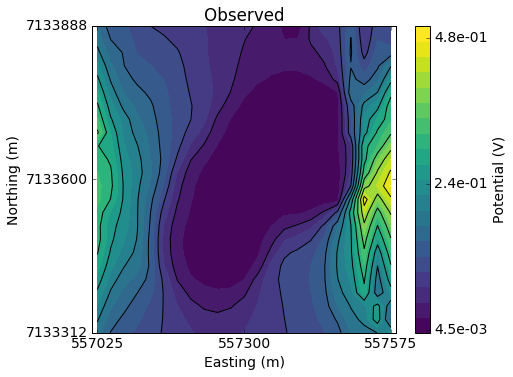

In [24]:
vizdata(dcdata, src1, rx_x, rxcomponent="X", title="Observed", figsave="./images/IxVx_obs.png", clim=(4.5e-3, 4.8e-1))

(7133300.0, 7133900.0)

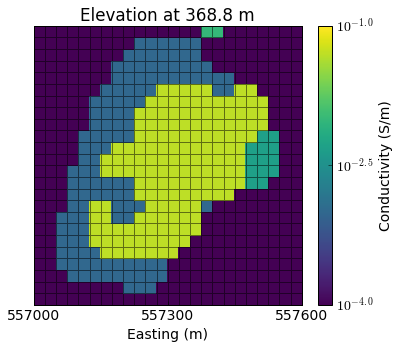

In [25]:
ax = viz(mesh, sigma, 28, airind, normal="Z", xc=xc, yc=yc, zc=zc)
xmin, xmax = -300+xc, 300+xc
ymin, ymax = -300+yc, 300+yc
ax.set_xticks(np.linspace(xmin, xmax, 3))
ax.set_yticks([]); ax.set_ylabel('')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)


In [26]:
# fig, ax = plt.subplots(1,1, figsize=(5,4))
# a = ax.hist(np.log10(dobs[dobs>0.]), bins=100)
# b = ax.hist(np.log10(-dobs[dobs<0.]), bins=100, color='r', alpha=0.5)

In [27]:
depth = 1./(abs(mesh.gridCC[:,2]-zc))**1.5
depth = depth/depth.max()

(-175.0, 425.0)

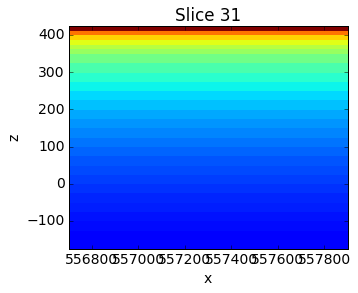

In [28]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
mesh.plotSlice(np.log10(depth), normal="Y", streamOpts={'color':'w'}, ax=ax)
ax.set_xlim(-600+xc, 600+xc)
ax.set_ylim(-600+zc, 0.+zc)    

## Without dept weight

In [29]:
# from SimPEG import DataMisfit, Regularization, Optimization, Directives, InvProblem, Inversion
# regmap = Maps.IdentityMap(nP=m0.size)
# std = 0.05
# eps = 1e-3
# survey.std = std
# survey.eps = eps
# #TODO put warning when dobs is not set!
# survey.dobs = dobs
# dmisfit = DataMisfit.l2_DataMisfit(survey)
# reg = Regularization.Simple(mesh, mapping=regmap, indActive=~airind)
# # reg.wght = depth[~airind]
# opt = Optimization.InexactGaussNewton(maxIter = 20)
# invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
# # Create an inversion object
# beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=2)
# betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
# save = Directives.SaveOutputEveryIteration()
# target = Directives.TargetMisfit()
# inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest, save, target])
# reg.alpha_s = 1e-4
# reg.alpha_x = 1.
# reg.alpha_y = 1.
# reg.alpha_z = 1.
# problem.counter = opt.counter = Utils.Counter()
# opt.LSshorten = 0.5
# opt.remember('xc')
# mopt = inv.run(m0)
# sigopt = mapping*mopt
# np.save("sigest_singlesrc_nodweights", sigopt)

## With depth weight

In [30]:
# from SimPEG import DataMisfit, Regularization, Optimization, Directives, InvProblem, Inversion
# regmap = Maps.IdentityMap(nP=m0.size)
# std = 0.05
# eps = 1e-3
# survey.std = std
# survey.eps = eps
# #TODO put warning when dobs is not set!
# survey.dobs = dobs
# dmisfit = DataMisfit.l2_DataMisfit(survey)
# reg = Regularization.Simple(mesh, mapping=regmap, indActive=~airind)
# reg.wght = depth[~airind]
# opt = Optimization.InexactGaussNewton(maxIter = 20)
# invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
# # Create an inversion object
# beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=2)
# betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
# save = Directives.SaveOutputEveryIteration()
# target = Directives.TargetMisfit()
# inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest, save, target])
# reg.alpha_s = 1e-4
# reg.alpha_x = 1.
# reg.alpha_y = 1.
# reg.alpha_z = 1.
# problem.counter = opt.counter = Utils.Counter()
# opt.LSshorten = 0.5
# opt.remember('xc')
# mopt = inv.run(m0)
# sigopt = mapping*mopt
# np.save("sigest_singlesrc_withdweights", sigopt)

In [31]:
sigopt_withdepth = np.load("sigest_singlesrc_withdweights.npy")
sigopt_nodepth = np.load("sigest_singlesrc.npy")
dpred = survey.dpred(np.log(sigopt_withdepth[~airind]))

In [32]:
from SimPEG import Survey
# datapred = invProb.dpred
obsdata = Survey.Data(survey, v=dobs)
preddata = Survey.Data(survey, v=dpred)

In [33]:
# figsize(8,3)
# plt.plot(obsdata[src1, rx_y])
# plt.plot(preddata[src1, rx_y], '.')

<function __main__.<lambda>>

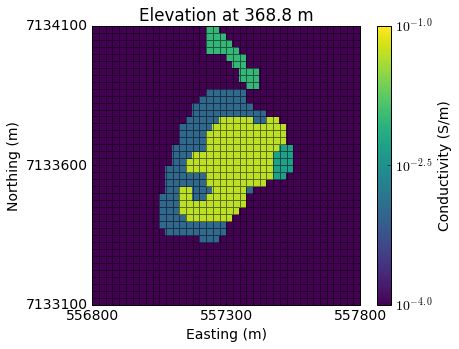

In [34]:
interact(lambda ind: viz(mesh, sigma, ind, airind=airind, normal="Z", xc=xc,yc=yc,zc=zc), ind=IntSlider(min=0, max=32,step=1, value=28))

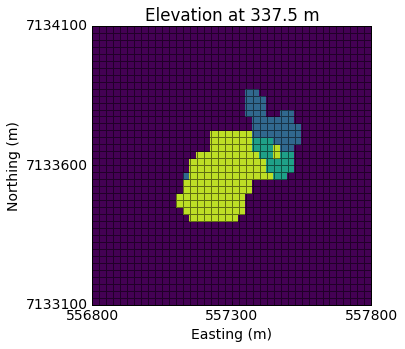

In [60]:
viz(mesh, sigma, 26, airind=airind, normal="Z", xc=xc,yc=yc,zc=zc, cb=False)
ax.set_yticks([]); ax.set_ylabel('')

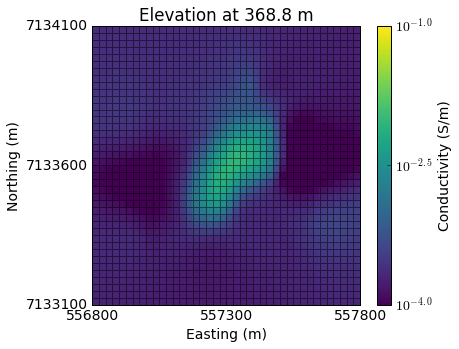

In [45]:
viz(mesh, sigopt_nodepth, 28, airind=airind, normal="Z", xc=xc,yc=yc,zc=zc)

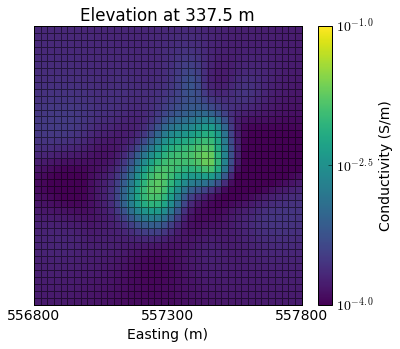

In [55]:
ax = viz(mesh, sigopt_withdepth, 26, airind=airind, normal="Z", xc=xc,yc=yc,zc=zc)
# ax.set_xticks(np.linspace(xmin, xmax, 3))
ax.set_yticks([]); ax.set_ylabel('')


<function __main__.<lambda>>

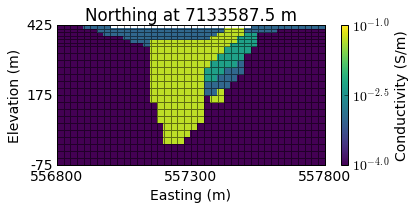

In [37]:
interact(lambda ind: viz(mesh, sigma, ind, airind=airind, normal="Y", xc=xc,yc=yc,zc=zc), ind=IntSlider(min=0, max=32,step=1, value=30))

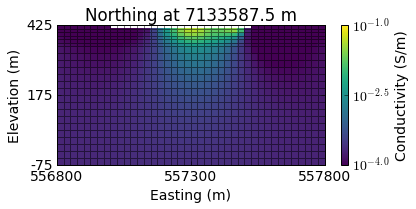

In [43]:
viz(mesh, sigopt_nodepth, 30, airind=airind,  normal="Y", xc=xc,yc=yc,zc=zc)

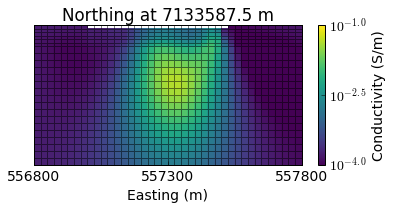

In [53]:
ax = viz(mesh, sigopt_withdepth, 30, airind=airind,  normal="Y", xc=xc,yc=yc,zc=zc)
ax.set_yticks([]); ax.set_ylabel('')


In [40]:
# vizdata(obsdata, src1, rx_x, rxcomponent="X", title="Ix and Vx")

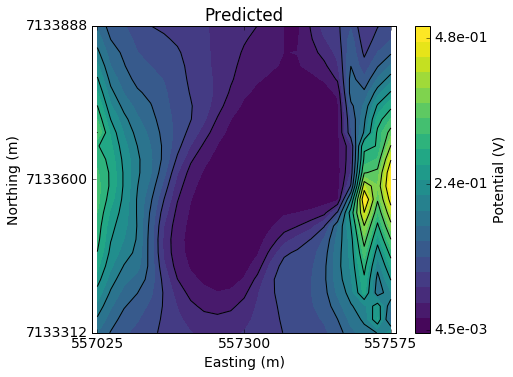

In [41]:
vizdata(preddata, src1, rx_x, rxcomponent="X", title="Predicted", figsave="./images/IxVx_pred.png", clim=(4.5e-3, 4.8e-1))

In [42]:
# import pickle
# Results = {"model_true":sigma, "model_pred":sigopt, "Obs":dobs, "Pred":dpred}
# outputs = open("DCresults", 'wb')
# pickle.dump(Results, outputs)
# outputs.close()